In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (11,6)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/home/alexander/miniconda3/envs/2_ml/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Hot hand fallacy?

In [2]:
streak, N, num_experiments = 3, 20, 100000
results, results_streak = [], []
for _ in range(num_experiments):
    x = np.random.randint(2, size=N)
    after_streak = np.array([ i+streak for i in range(N) if np.all(x[i:i+streak] == 1) and (i+streak < N) ])
    if len(after_streak) > 0:
        results_streak.append(np.sum(x[after_streak]) / len(after_streak))
    results.append(np.sum(x) / float(N))

In [3]:
np.mean(results_streak)

0.361665042880031

In [5]:
np.mean(results_streak)

0.361665042880031

In [6]:
streak, N, num_experiments = 3, 20, 20000
res = {}
for streak in range(1, 6):
    print("Streak %d..." % streak)
    res[streak] = {}
    for N in [ i for i in range(streak+1, 20)] + [i for i in range(20, 101, 5)]:
        x = np.random.randint(2, size=(num_experiments, N))
        after_streak = [ [i+streak for i in range(N) if np.all(x[j,i:i+streak] == 1) and (i+streak < N)] for j in range(num_experiments) ]
        after_streak_avg = [ np.mean(x[j,a]) for (j,a) in enumerate(after_streak) if len(a) > 0 ]
        res[streak][N] = np.mean(after_streak_avg)

Streak 1...
Streak 2...
Streak 3...
Streak 4...
Streak 5...


In [7]:
np.mean(after_streak_avg)

0.3641441123200042

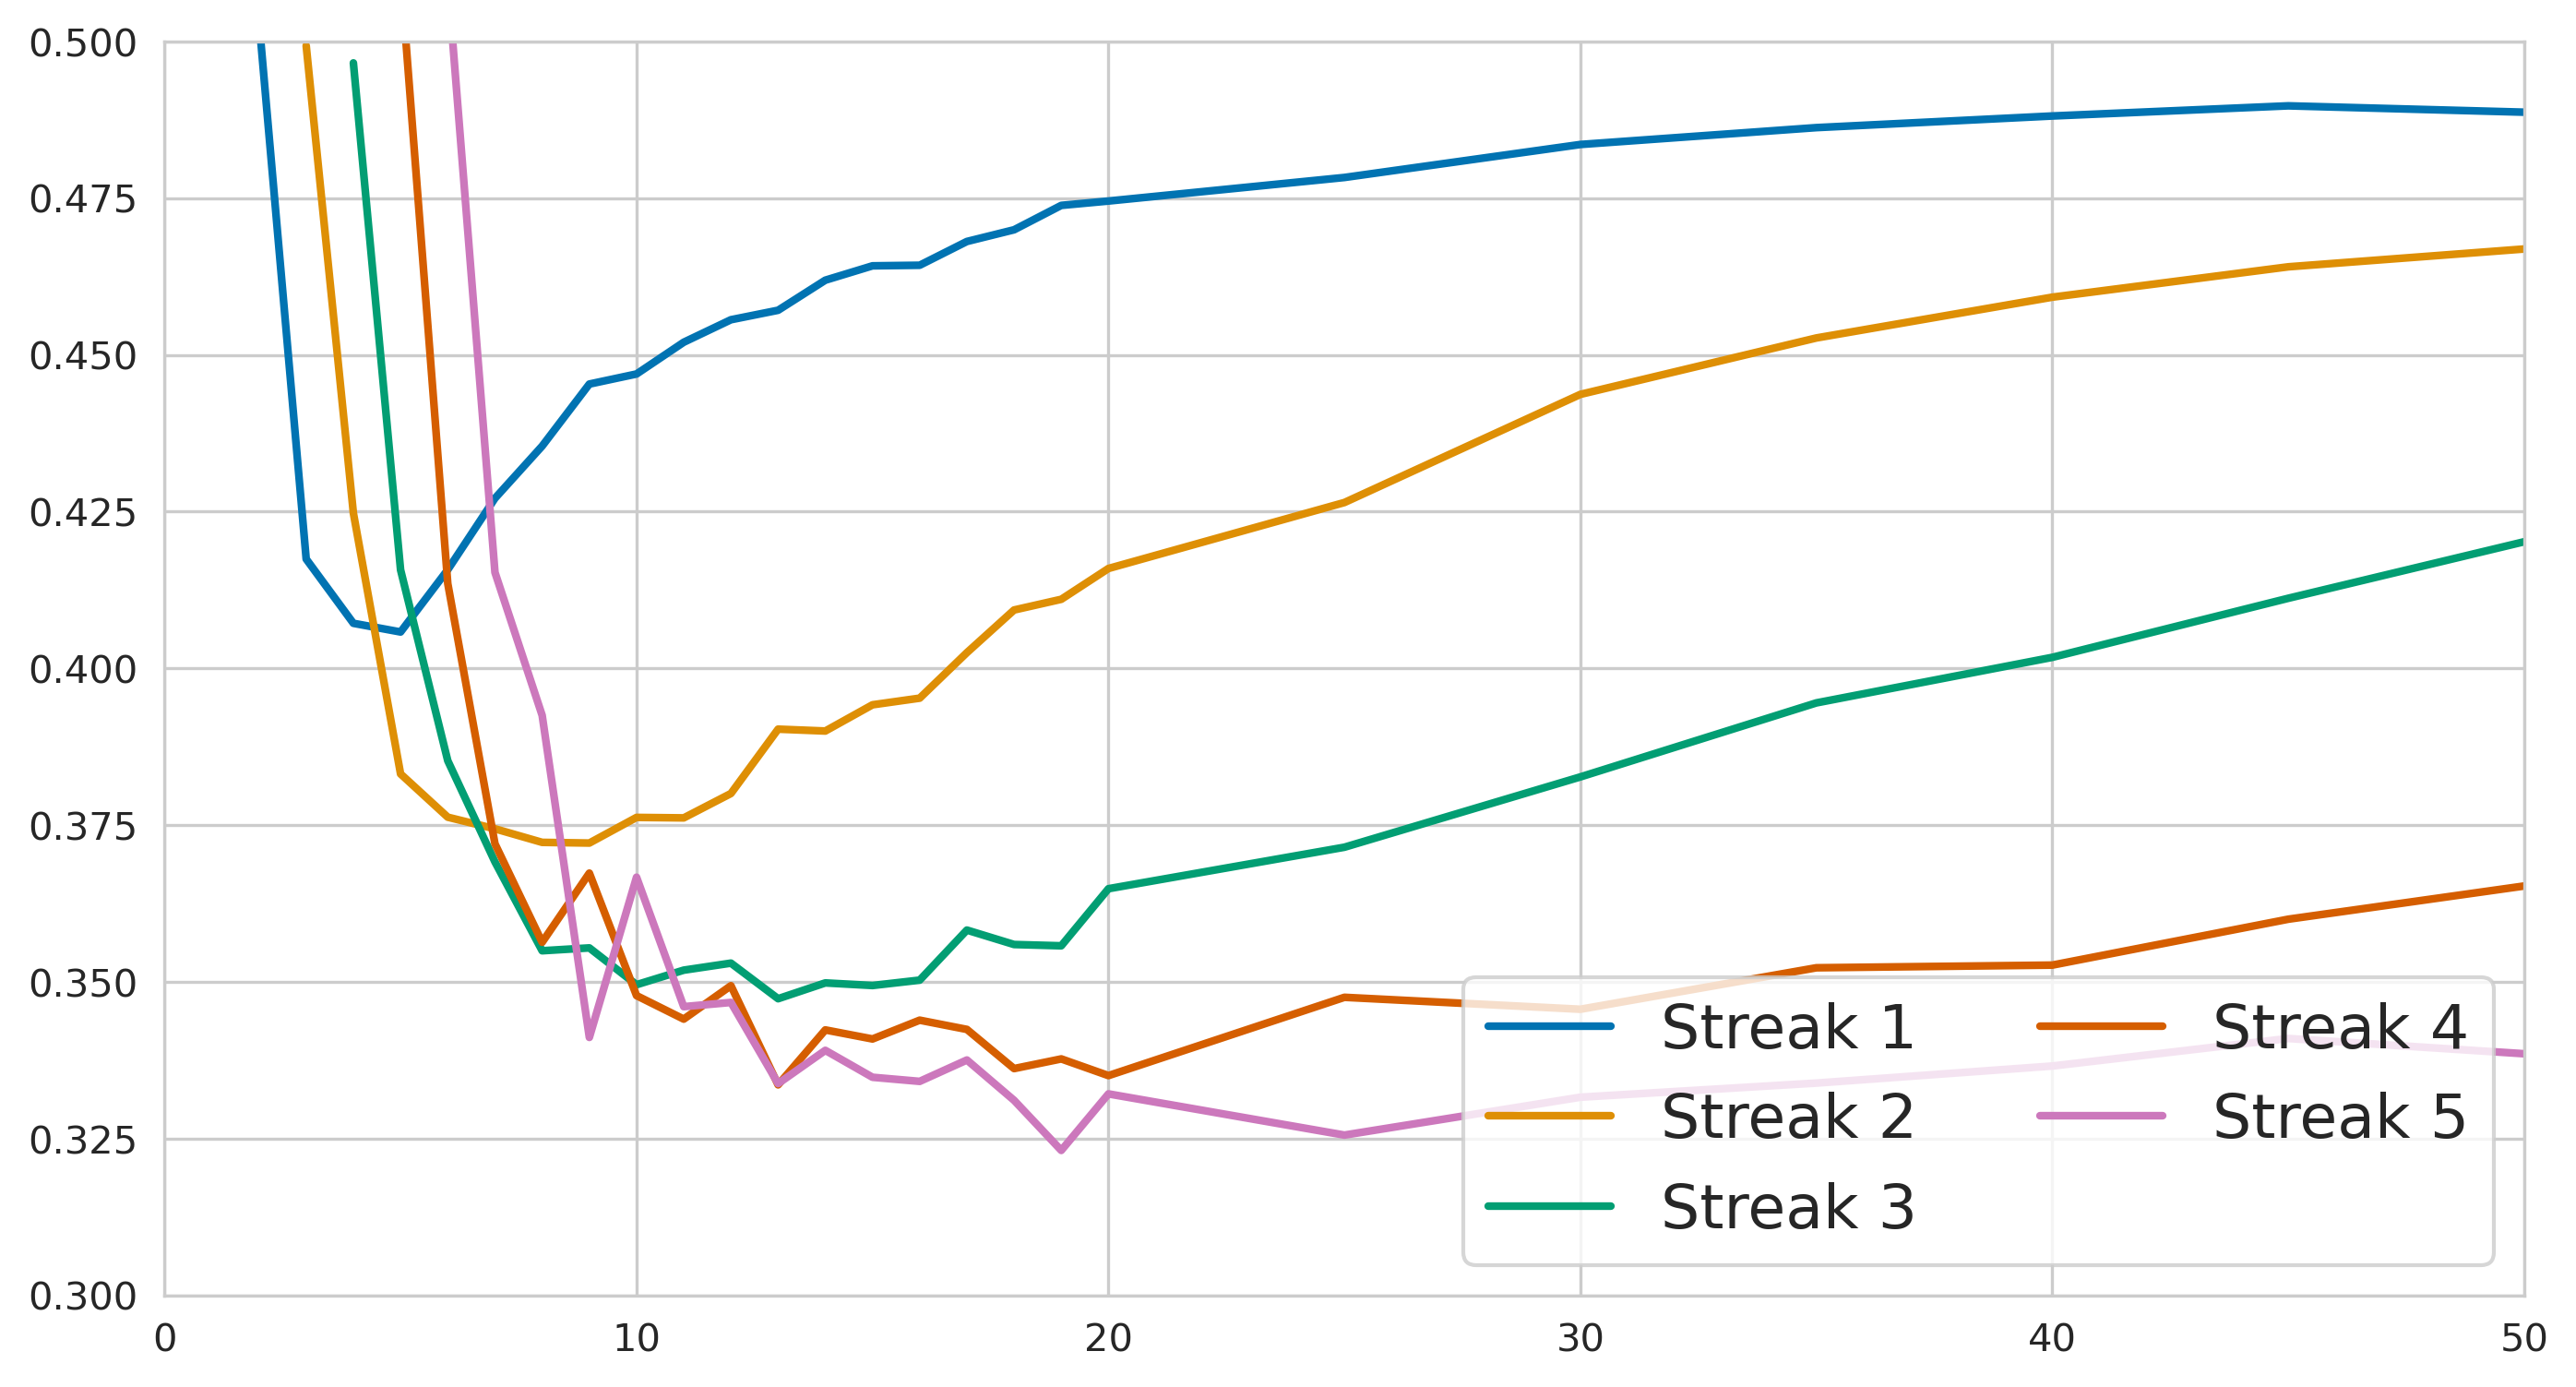

In [8]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for streak in range(1, 6):
    xs = sorted(res[streak].keys())
    ax.plot(xs, [res[streak][x] for x in xs], linewidth=2, label="Streak %d" % streak)
ax.set_xlim((0, 50))
ax.set_ylim((.3, 0.5))
ax.legend(loc="lower right", ncol=2, fontsize=legend_fontsize)
# plt.savefig("hothand.pdf", bbox_inches='tight')
plt.show()

# Байесовский вывод для испытаний Бернулли

/home/alexander/miniconda3/envs/2_ml/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


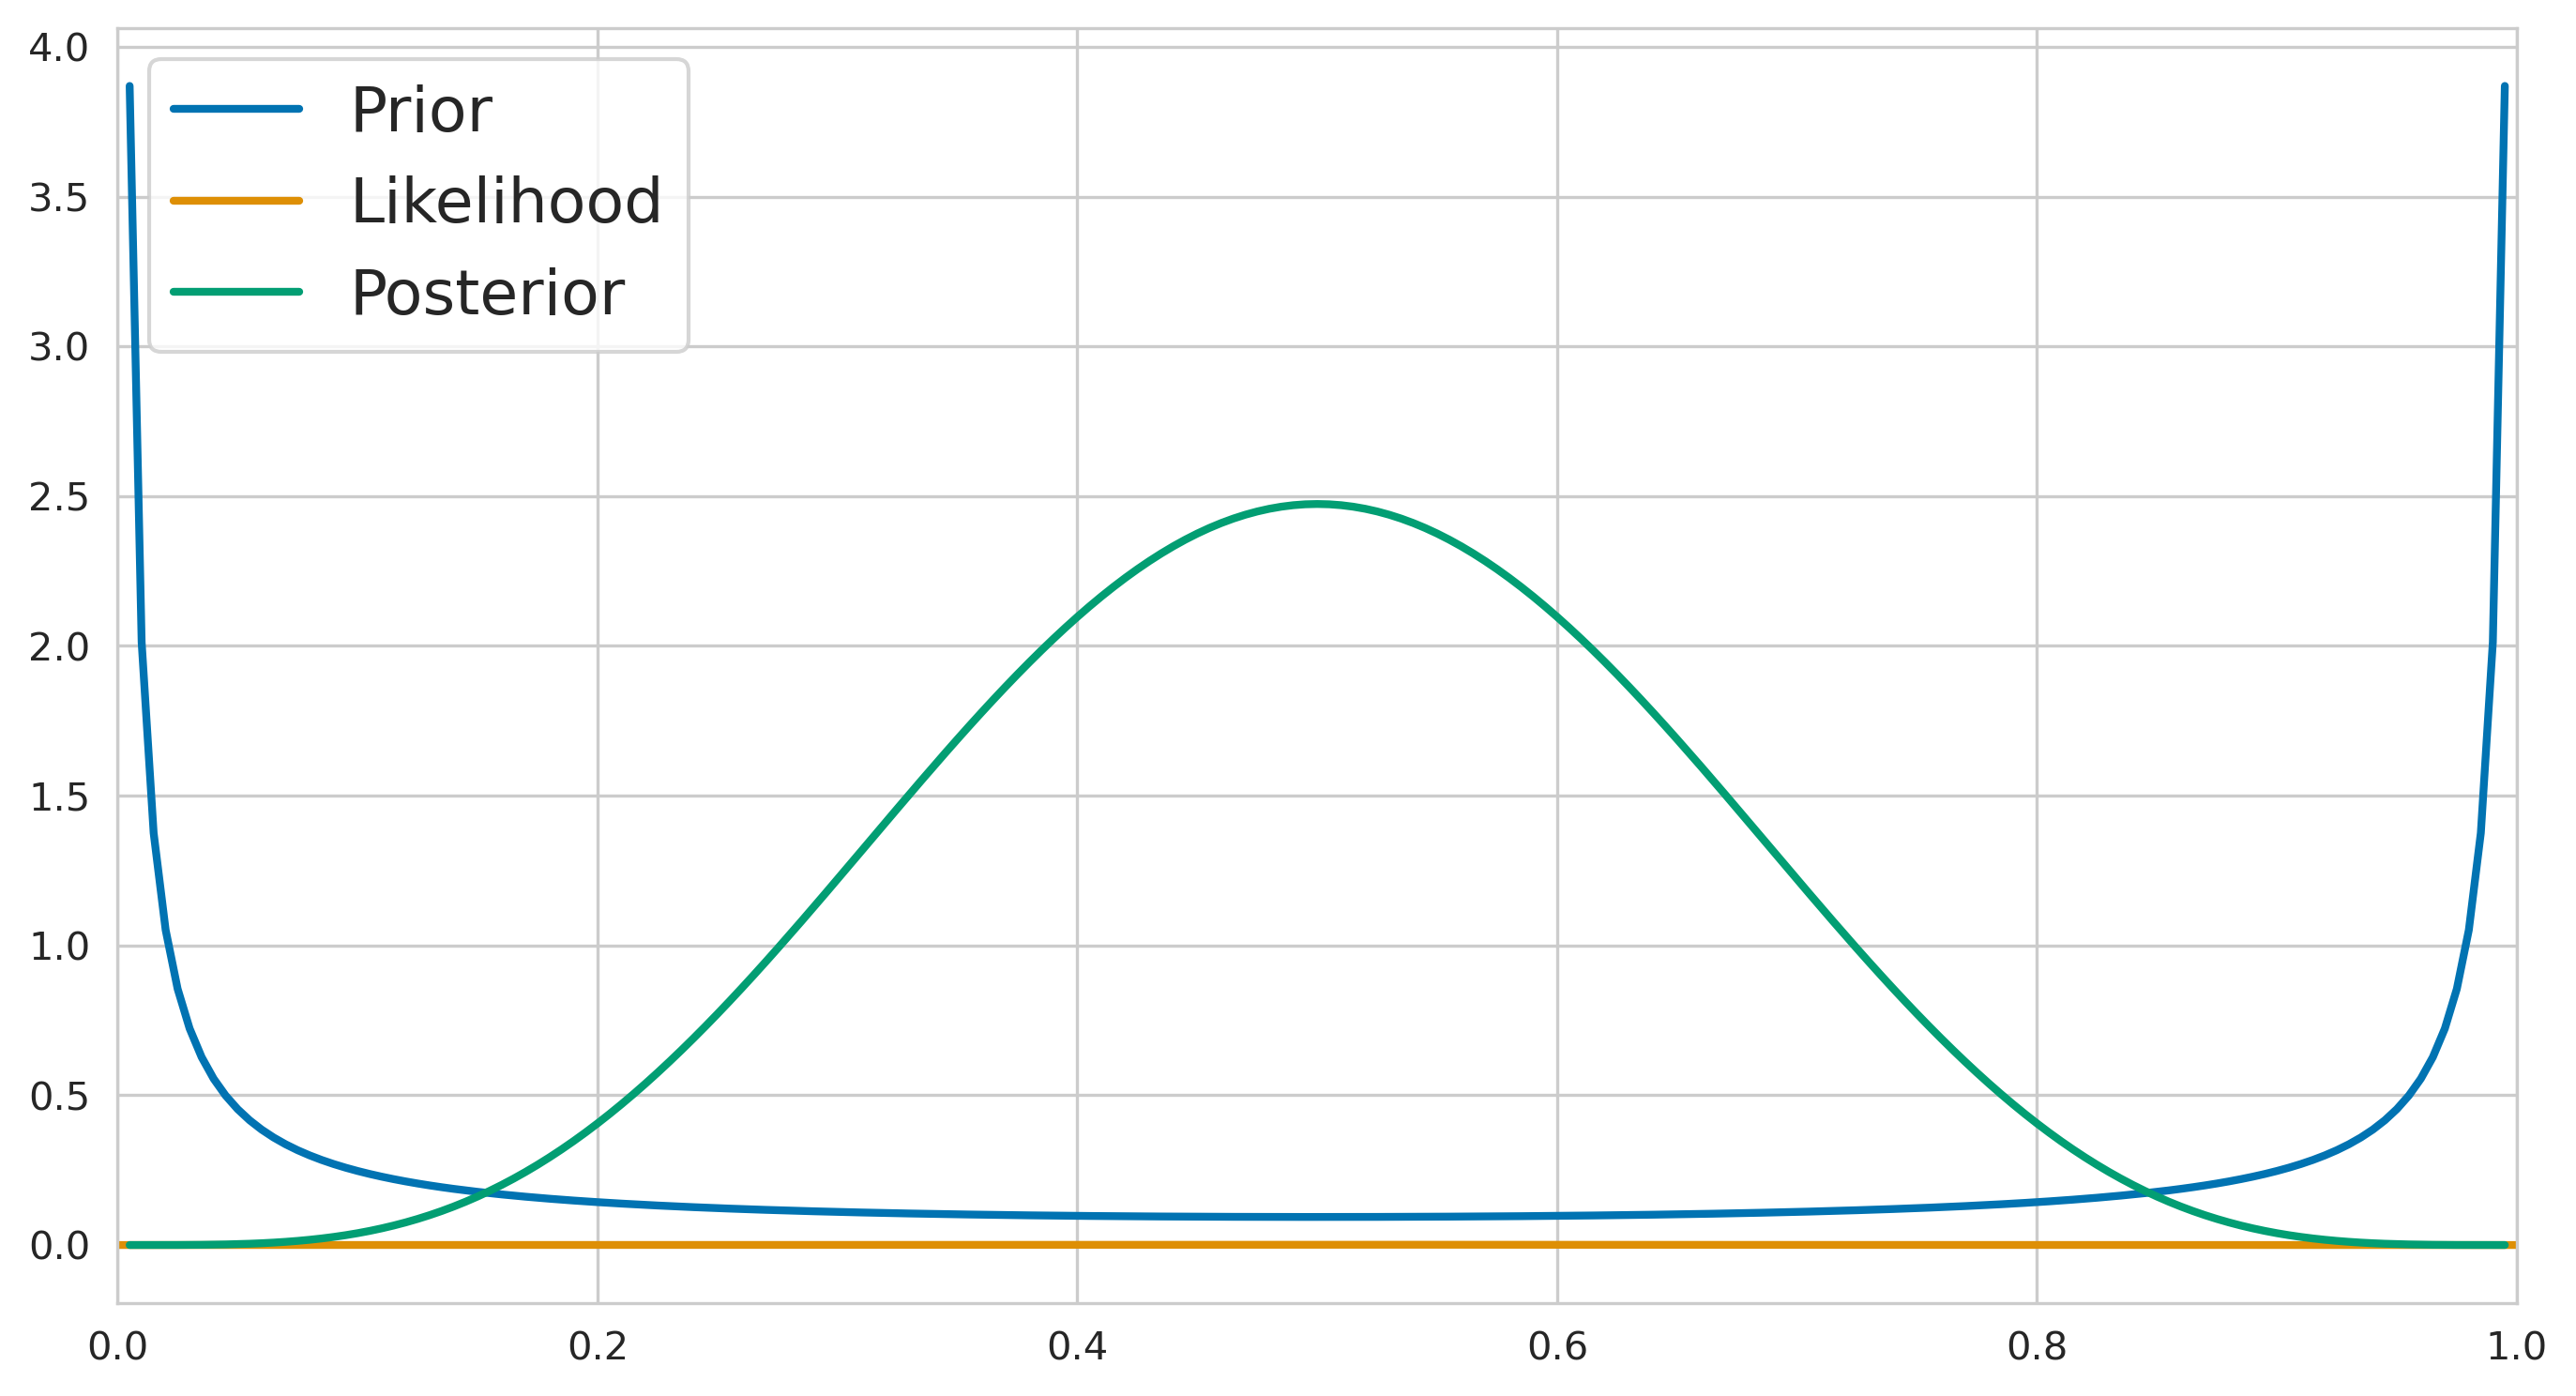

In [9]:
xs = np.arange(-0.01, 1.01, 0.005)

prior_params = (.05, .05)
experimental_data = (5, 5)

## Априорное распределение
pri = st.beta(prior_params[0], prior_params[1]).pdf
norm_prior = 1 #integrate.quad(lambda x: pri(x), -np.inf, np.inf)[0]
ys_prior = [ pri(x) / norm_prior for x in xs ]

## Правдоподобие
n_heads, n_tails = experimental_data
lk = lambda x : x ** n_heads * (1 - x) ** n_tails
ys_like = [ lk(x) for x in xs ]

## Апостериорное распределение
post = lambda x : lk(x) * pri(x)
norm_post = integrate.quad(lambda x: post(x), 0, 1)[0]
ys_post = [ post(x) / norm_post for x in xs ]

## И нарисуем
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(xs, ys_prior, linewidth=2, label="Prior")
ax.plot(xs, ys_like, linewidth=2, label="Likelihood")
ax.plot(xs, ys_post, linewidth=2, label="Posterior")
ax.set_xlim((-.0, 1.0))
ax.legend(loc="upper left", fontsize=legend_fontsize)
plt.show()

## Полиномиальная регрессия и оверфиттинг

In [10]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .25, num_points)

## X-координаты точек данных
xd_large = np.arange(-1.5, 2, 0.05)
num_points_l = len(xd_large)

## Данные
data_large = orig(xd_large) + np.random.normal(0, .25, num_points_l)


## Для рисования
xs = np.arange(xd[0]-.5, xd[-1]+.5, 0.01)


[0.17679239]


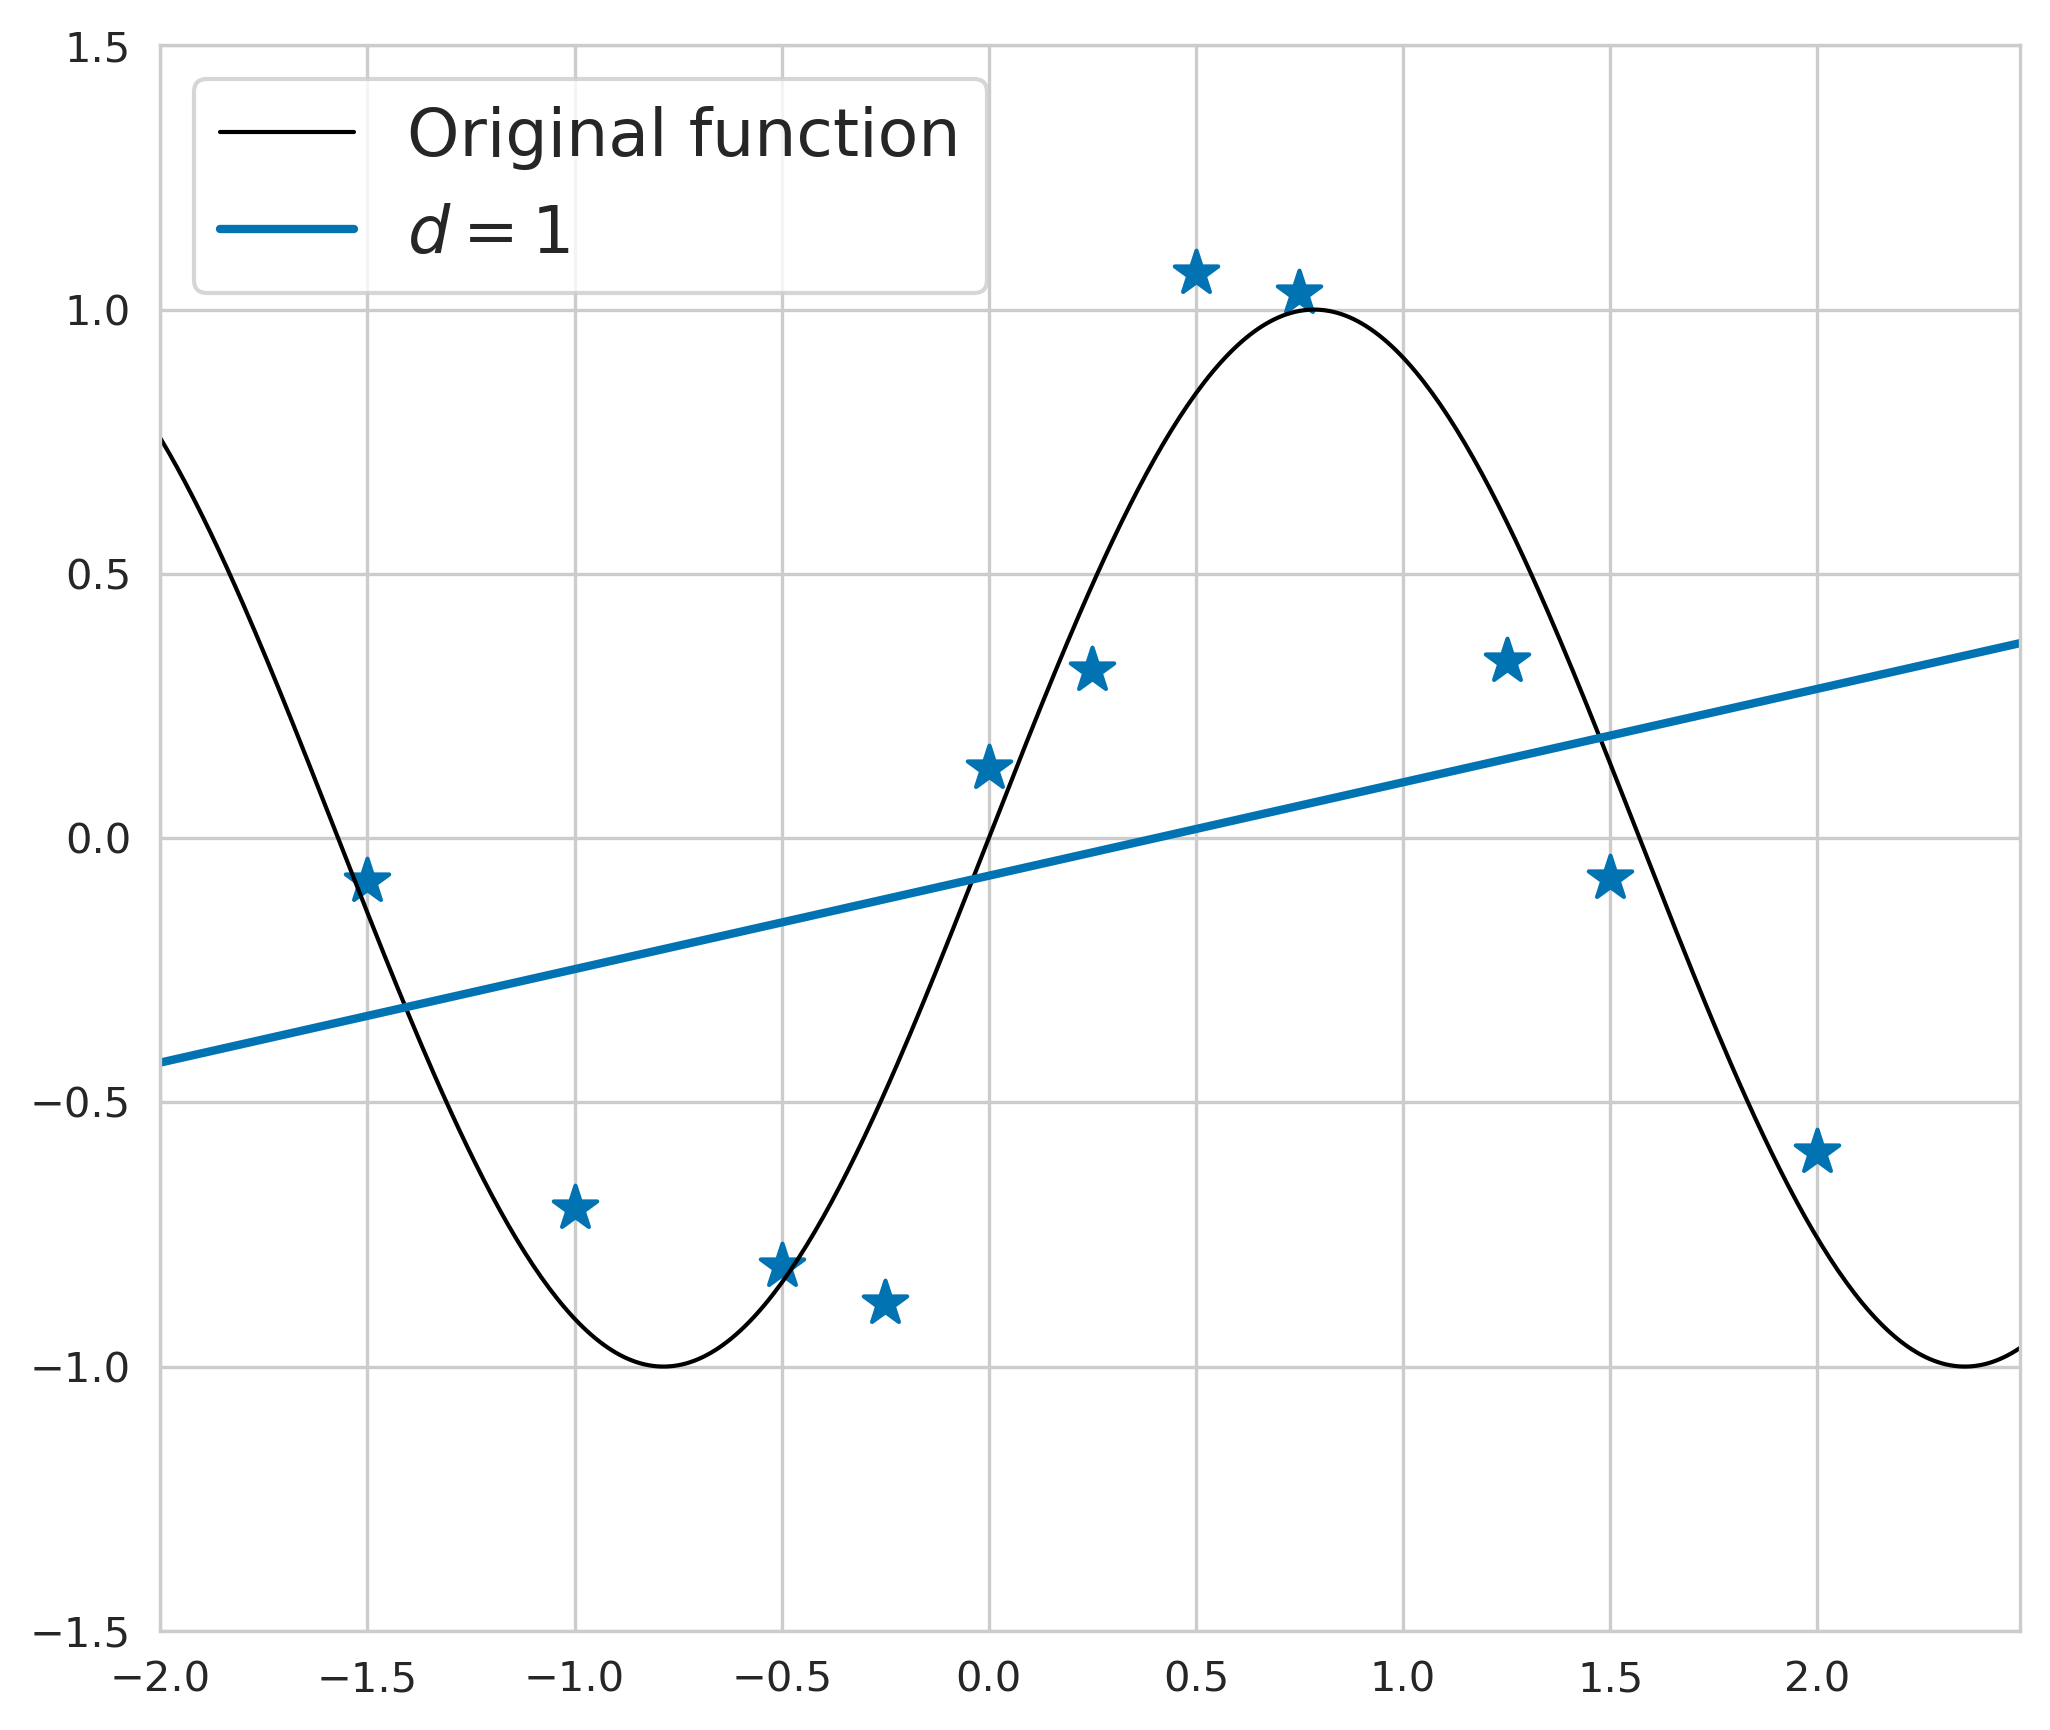

In [11]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [ 1, ]

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-1.5, 1.5))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Original function", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], data )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper left", fontsize=legend_fontsize)
# plt.savefig("linregr1.pdf", bbox_inches='tight')
plt.show()